# 프로젝트 개요

1. 기획
- 데이터 생성
 - id: 고객 아이디
 - sex: 성별
 - age: 나이 (20 ~ 70)
 - address: 배송권역
 - product: 제품
 - value: 제품 가격
 - amt: 수량
 - total: 구매총액

- What: 신규 고객에게 구매할 제품을 추천한다
- How: 기존 고객의 가을 ~겨울 기간의 구매 내역 분석해 신규 고객에게 적용한다
- Who: 신규 고객 대상

2. 전처리
- 분석에 불필요한 id 제거, sex, address 수치형 변환
- 제품 가격, 구매 수량, 구매총액 제거
- 항목별로 제품 그룹화
- 각 항목에 가중치 부여(기준 : 전년도 09 ~ 금년 02월 판매량)
- target 지정

3. 예측모델 생성 - 머신러닝
- Logistic Regression
- KNN(K-nearest neighbor)
- Decision Tree
- Random Forest
- **최종 모델 선정: LogisticRegression**

4. 예측

# 필수 라이브러리 로딩

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 6 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,834 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120882 files and direc

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('font', family = 'NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
import matplotlib.font_manager as fm
import seaborn as sns

import random

from sklearn.model_selection import cross_validate , train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# DataFrame 생성

In [3]:
# 인적 사항 테이블 생성
# id 컬럼 생성
id = []
for _ in range(1000):
  id.append(random.randint(1,20)) # id는 고유번호이며 , 1000개의 id를 생성 후 각각의 id마다 구매횟수 1회~~20회 부여

In [4]:
data = pd.DataFrame({'id' : np.arange(1,1001)})

In [5]:
# 성별 컬럼 생성
sex = []
for i in range(700):
  sex.append('female')
for i in range(300):
  sex.append('male')

In [6]:
a = random.sample(range(1000),1000)

In [7]:
len(sex) , len(a)

(1000, 1000)

In [8]:
result = []
for i in range(1000):
  result.append(sex[a[i]])

In [9]:
data['sex'] = result

In [10]:
data

,id,sex
0,1,male
1,2,male
2,3,male
3,4,female
4,5,female
...,...,...
995,996,female
996,997,female
997,998,female
998,999,male


In [11]:
# 나이 컬럼 생성
age = []
for i in range(600):
  age.append(random.randint(20,39))

In [12]:
for i in range(400):
  age.append(random.randint(40,70))

In [13]:
data['age'] = age

<Axes: ylabel='Frequency'>

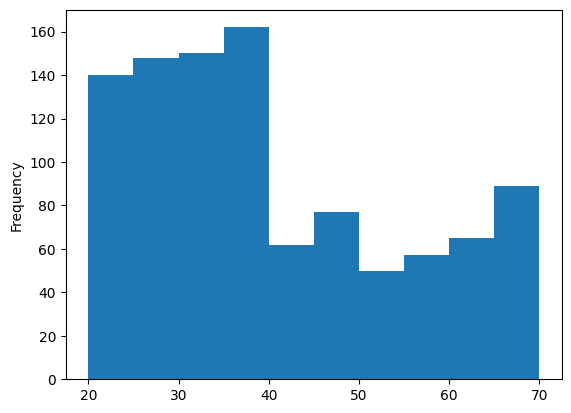

In [14]:
data.age.plot(kind = 'hist') # 나이의 분포 , 20~30대가 60% 이상이다.

In [15]:
# 주소 컬럼 생성
address = ['서울','인천','대구','대전','광주','부산','제주','경기도','강원도','전라도','경상도'] # 주소는 이 11개의 지역으로 나누어서 택배업체가 있는 것으로 가정

In [16]:
add = []
for i in range(1000):
  add.append(random.randint(0,10))

In [17]:
result2 = []
for i in range(1000):
  result2.append(address[add[i]])

In [18]:
data['address'] = result2

In [19]:
data.head() # 무작위로 주소 기입

,id,sex,age,address
0,1,male,28,경상도
1,2,male,34,경상도
2,3,male,23,대전
3,4,female,38,전라도
4,5,female,29,광주


In [20]:
data.address

0      경상도
1      경상도
2       대전
3      전라도
4       광주
      ... 
995     인천
996     광주
997    경상도
998     인천
999     대구
Name: address, Length: 1000, dtype: object

<BarContainer object of 11 artists>

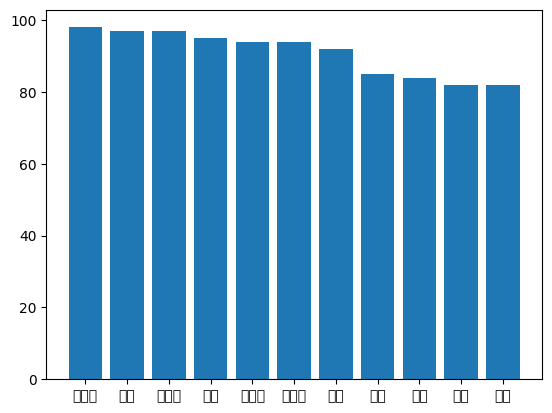

In [21]:
# 주소의 분포
plt.bar(data.address.unique() , data.address.value_counts().values)

In [22]:
# 거래내역 테이블 생성
data_list = []
for i in range(1000):
  for j in range(id[i]):
    data_list.append(data['id'].tolist()[i]) # 구매 횟수만큼 id를 data_list에 추가


In [23]:
len(data_list) # 10455개의 행이 될 예정

10767

In [24]:
df = pd.DataFrame({'id' : data_list})

In [25]:
# 인적 사항 테이블 + 거래 내역 테이블 결합
result_df = pd.merge(df , data , on = 'id') # 앞서 성별 , 나이 , 주소를 적은 데이터프레임과 10455개의 행을 id를 기준으로 합치기

In [26]:
result_df # 결과

,id,sex,age,address
0,1,male,28,경상도
1,1,male,28,경상도
2,1,male,28,경상도
3,1,male,28,경상도
4,1,male,28,경상도
...,...,...,...,...
10762,999,male,67,인천
10763,999,male,67,인천
10764,1000,female,61,대구
10765,1000,female,61,대구


In [27]:
result_df.to_csv('shopping_result2.csv' , encoding = 'euc-kr' , index = False)

In [28]:
df = pd.read_csv('shopping_result2.csv', encoding = 'euc-kr')
df.head()

,id,sex,age,address
0,1,male,28,경상도
1,1,male,28,경상도
2,1,male,28,경상도
3,1,male,28,경상도
4,1,male,28,경상도


In [29]:
# 상품의 종류 및 가격 책정
female_p = {'여성용 구두':120000,
'여성용 벨트':39000,
'여성용 블라우스':40000,
'여성용 셔츠':40000,
'여성용 스웨터':40000,
'여성용 스포츠웨어':50000,
'여성용 슬랙스':40000,
'여성용 양말':2000,
'여성용 원피스':45000,
'여성용 잠옷':35000,
'여성용 지갑':70000,
'여성용 진':40000,
'여성용 치마':39000,
'여성용 코트':300000,
'여성용 티셔츠':40000,
'여성용 패딩':200000,
'여성용 후리스':30000}

male_p = {'남성용 구두':120000,
'남성용 벨트':39000,
'남성용 셔츠':30000,
'남성용 스웨터':40000,
'남성용 스포츠웨어':50000,
'남성용 슬랙스':40000,
'남성용 양말':2000,
'남성용 잠옷':35000,
'남성용 지갑':70000,
'남성용 진':40000,
'남성용 코트':250000,
'남성용 티셔츠':40000,
'남성용 패딩':200000,
'남성용 후리스':30000}

In [30]:
# 성별 인원 확인
df['sex'].value_counts()

female    7545
male      3222
Name: sex, dtype: int64

In [35]:
# 90% 인원 수 확인
7545 * 0.9, 3222 * 0.9

(6790.5, 2899.8)

In [36]:
# 여성 고객일 경우 여성 물품 90% , 남성 물품 10% 비율로 , 남성 고객일 경우 남성 물품 90% , 여성 물품 10% 비율로 추가
female_products = list(female_p.keys())
male_products = list(male_p.keys())
f_result = []
m_result = []


for i in range(6790):
    f_result.append(np.random.choice(female_products))
for i in range(6790, 7545):
    f_result.append(np.random.choice(male_products))

for i in range(2899):
  m_result.append(np.random.choice(male_products))
for i in range(2899, 3222):
  m_result.append(np.random.choice(female_products))

In [37]:
# 리스트 섞기
random.shuffle(f_result)
random.shuffle(m_result)

In [38]:
# 여성인 경우 f_result, 남성인 경우 m_result로 product열 생성
female_condition = df['sex'] == 'female'
df.loc[female_condition, 'product'] = f_result
df.loc[~female_condition, 'product'] = m_result

In [39]:
# 사전을 결합해 value열에 해당 제품의 가격 입력
combined_dict = female_p | male_p
df['value'] = df['product'].map(combined_dict)

In [40]:
df.to_csv('shopping_result3.csv', encoding = 'euc-kr', index = False)

In [41]:
df = pd.read_csv('shopping_result3.csv' , encoding = 'euc-kr')

In [42]:
df

,id,sex,age,address,product,value
0,1,male,28,경상도,남성용 진,40000
1,1,male,28,경상도,여성용 코트,300000
2,1,male,28,경상도,여성용 벨트,39000
3,1,male,28,경상도,남성용 티셔츠,40000
4,1,male,28,경상도,여성용 스웨터,40000
...,...,...,...,...,...,...
10762,999,male,67,인천,남성용 티셔츠,40000
10763,999,male,67,인천,남성용 셔츠,30000
10764,1000,female,61,대구,여성용 셔츠,40000
10765,1000,female,61,대구,여성용 벨트,39000


In [43]:
# 상품의 수량 및 가격 컬럼 생성
products = df['product']

rand = []
for product in products:
    if '코트' in product or '패딩' in product or '후리스' in product:  # 코트, 패딩, 후리스는 1~3개의 수량
        random_number = random.randint(1, 3)
        rand.append(random_number)
    elif '양말' in product:  # 양말은 3~10개의 수량
        random_number = random.randint(3, 10)
        rand.append(random_number)
    else:  # 그외에 나머지는 1~6개의 수량으로 책정
        random_number = random.randint(1,6)
        rand.append(random_number)

In [44]:
# 구매 상품의 수량 컬럼
df['amt'] = rand

In [45]:
# 상품의 가격 * 상품의 구매 개수 = 총 구매액 컬럼 생성
df['total'] = df['value'] * df['amt']

# 데이터 로딩

In [46]:
df4 = df

In [47]:
# product열을 더미로 변환
result4 = pd.concat([df4 , pd.get_dummies(df4['product'])] , axis = 1)

In [48]:
result4

,id,sex,age,address,product,value,amt,total,남성용 구두,남성용 벨트,...,여성용 양말,여성용 원피스,여성용 잠옷,여성용 지갑,여성용 진,여성용 치마,여성용 코트,여성용 티셔츠,여성용 패딩,여성용 후리스
0,1,male,28,경상도,남성용 진,40000,3,120000,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,male,28,경상도,여성용 코트,300000,3,900000,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,male,28,경상도,여성용 벨트,39000,2,78000,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,male,28,경상도,남성용 티셔츠,40000,6,240000,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,male,28,경상도,여성용 스웨터,40000,3,120000,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10762,999,male,67,인천,남성용 티셔츠,40000,3,120000,0,0,...,0,0,0,0,0,0,0,0,0,0
10763,999,male,67,인천,남성용 셔츠,30000,5,150000,0,0,...,0,0,0,0,0,0,0,0,0,0
10764,1000,female,61,대구,여성용 셔츠,40000,2,80000,0,0,...,0,0,0,0,0,0,0,0,0,0
10765,1000,female,61,대구,여성용 벨트,39000,6,234000,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
result4.iloc[:,8:] = result4.iloc[:,8:].apply(lambda x : x*result4.amt) # 이 더미에서 개수를 추가하여 , 카테고리마다 몇 개를 샀는지 등록

In [50]:
result4.columns

Index(['id', 'sex', 'age', 'address', 'product', 'value', 'amt', 'total',
       '남성용 구두', '남성용 벨트', '남성용 셔츠', '남성용 스웨터', '남성용 스포츠웨어', '남성용 슬랙스',
       '남성용 양말', '남성용 잠옷', '남성용 지갑', '남성용 진', '남성용 코트', '남성용 티셔츠', '남성용 패딩',
       '남성용 후리스', '여성용 구두', '여성용 벨트', '여성용 블라우스', '여성용 셔츠', '여성용 스웨터',
       '여성용 스포츠웨어', '여성용 슬랙스', '여성용 양말', '여성용 원피스', '여성용 잠옷', '여성용 지갑',
       '여성용 진', '여성용 치마', '여성용 코트', '여성용 티셔츠', '여성용 패딩', '여성용 후리스'],
      dtype='object')

In [51]:
result5 = result4.groupby(['id','sex','age','address'])[['남성용 구두', '남성용 벨트', '남성용 셔츠', '남성용 스웨터', '남성용 스포츠웨어', '남성용 슬랙스',
       '남성용 양말', '남성용 잠옷', '남성용 지갑', '남성용 진', '남성용 코트', '남성용 티셔츠', '남성용 패딩',
       '남성용 후리스', '여성용 구두', '여성용 벨트', '여성용 블라우스', '여성용 셔츠', '여성용 스웨터',
       '여성용 스포츠웨어', '여성용 슬랙스', '여성용 양말', '여성용 원피스', '여성용 잠옷', '여성용 지갑',
       '여성용 진', '여성용 치마', '여성용 코트', '여성용 티셔츠', '여성용 패딩', '여성용 후리스']].sum()

In [52]:
result5 = result5.reset_index()

In [53]:
result5['sex'] = np.where(result5.sex == 'female' , 0 , 1) # 성별을 남자 : 1 , 여자 : 0으로 나누기

In [54]:
result5

,id,sex,age,address,남성용 구두,남성용 벨트,남성용 셔츠,남성용 스웨터,남성용 스포츠웨어,남성용 슬랙스,...,여성용 양말,여성용 원피스,여성용 잠옷,여성용 지갑,여성용 진,여성용 치마,여성용 코트,여성용 티셔츠,여성용 패딩,여성용 후리스
0,1,1,28,경상도,2,0,0,10,0,0,...,0,0,0,0,0,0,3,0,0,0
1,2,1,34,경상도,0,5,0,6,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,23,대전,6,3,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,38,전라도,0,0,0,0,0,0,...,0,0,0,0,3,0,0,4,0,1
4,5,0,29,광주,0,3,0,0,0,0,...,16,3,8,0,0,0,7,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,0,70,인천,0,0,0,0,0,0,...,3,2,6,0,0,3,0,0,1,1
996,997,0,44,광주,0,0,0,2,4,0,...,0,0,0,0,0,0,4,0,0,0
997,998,0,62,경상도,0,0,6,6,0,0,...,8,1,7,1,6,0,2,0,2,2
998,999,1,67,인천,6,5,7,6,0,0,...,0,2,0,3,0,5,0,3,0,0


In [55]:
# 상품 카테고리 분류
accessory = ['남성용 벨트','남성용 지갑','남성용 양말','여성용 벨트','여성용 지갑','여성용 양말']

inner = ['남성용 셔츠', '남성용 스웨터', '남성용 스포츠웨어','남성용 슬랙스','남성용 잠옷','남성용 진','남성용 티셔츠',
         '여성용 블라우스','여성용 셔츠','여성용 스웨터','여성용 스포츠웨어','여성용 슬랙스','여성용 원피스','여성용 잠옷','여성용 진','여성용 치마','여성용 티셔츠']


out = ['남성용 코트','남성용 패딩','남성용 후리스','여성용 코트','여성용 패딩','여성용 후리스']

shoe = ['남성용 구두','여성용 구두']

In [56]:
# 각 상품별로 가중치 두기
# 악세서리 3.5 (양말 6), 이너 4, 아우터 1, 신발 1.5 ( 가중치 기준 : 6개월에 평균적으로 몇 개나 구매하는지)
target = [inner , out , shoe]
number = [1/4 , 1 , 2/3]

In [57]:
acc1 = ['남성용 벨트','남성용 지갑','여성용 벨트','여성용 지갑']
acc2 = ['남성용 양말','여성용 양말']

In [58]:
target = [inner  , out , shoe ,  acc1 , acc2]
number = [1/4  , 1  , 2/3 ,  2/7 , 1/6]

In [59]:
for i , j in zip(target , number):
  result5[i] = result5[i].apply(lambda x : round(x*j , 2)) # 가중지 주입 완료

In [60]:
result5

,id,sex,age,address,남성용 구두,남성용 벨트,남성용 셔츠,남성용 스웨터,남성용 스포츠웨어,남성용 슬랙스,...,여성용 양말,여성용 원피스,여성용 잠옷,여성용 지갑,여성용 진,여성용 치마,여성용 코트,여성용 티셔츠,여성용 패딩,여성용 후리스
0,1,1,28,경상도,1.33,0.00,0.00,2.5,0.00,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,3,0.00,0,0
1,2,1,34,경상도,0.00,1.43,0.00,1.5,0.25,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0,0
2,3,1,23,대전,4.00,0.86,0.00,1.5,0.00,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0,0
3,4,0,38,전라도,0.00,0.00,0.00,0.0,0.00,0.0,...,0.00,0.00,0.00,0.00,0.75,0.00,0,1.00,0,1
4,5,0,29,광주,0.00,0.86,0.00,0.0,0.00,0.0,...,2.67,0.75,2.00,0.00,0.00,0.00,7,0.00,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,0,70,인천,0.00,0.00,0.00,0.0,0.00,0.0,...,0.50,0.50,1.50,0.00,0.00,0.75,0,0.00,1,1
996,997,0,44,광주,0.00,0.00,0.00,0.5,1.00,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,4,0.00,0,0
997,998,0,62,경상도,0.00,0.00,1.50,1.5,0.00,0.0,...,1.33,0.25,1.75,0.29,1.50,0.00,2,0.00,2,2
998,999,1,67,인천,4.00,1.43,1.75,1.5,0.00,0.0,...,0.00,0.50,0.00,0.86,0.00,1.25,0,0.75,0,0


In [61]:
# 카테고리별 상품의 합계
result5['악세서리'] = result5[accessory].sum(axis = 1)

In [62]:
result5['이너'] = result5[inner].sum(axis = 1)

In [63]:
result5['아우터'] = result5[out].sum(axis = 1)

In [64]:
result5['신발'] = result5[shoe].sum(axis = 1)

In [65]:
result5.drop(['남성용 구두', '남성용 벨트', '남성용 셔츠', '남성용 스웨터', '남성용 스포츠웨어', '남성용 슬랙스',
       '남성용 양말', '남성용 잠옷', '남성용 지갑', '남성용 진', '남성용 코트', '남성용 티셔츠', '남성용 패딩',
       '남성용 후리스', '여성용 구두', '여성용 벨트', '여성용 블라우스', '여성용 셔츠', '여성용 스웨터',
       '여성용 스포츠웨어', '여성용 슬랙스', '여성용 양말', '여성용 원피스', '여성용 잠옷', '여성용 지갑',
       '여성용 진', '여성용 치마', '여성용 코트', '여성용 티셔츠', '여성용 패딩', '여성용 후리스'] , axis = 1 , inplace = True)

In [66]:
result5.columns

Index(['id', 'sex', 'age', 'address', '악세서리', '이너', '아우터', '신발'], dtype='object')

In [67]:
# 가장 많이 구매한 카테고리를 target으로 분류
max_column_name = result5[['악세서리','이너','아우터','신발']].idxmax(axis=1)

In [68]:
result5['target'] = max_column_name

In [69]:
result5

,id,sex,age,address,악세서리,이너,아우터,신발,target
0,1,1,28,경상도,1.43,6.00,7,1.33,아우터
1,2,1,34,경상도,4.24,2.75,5,0.00,아우터
2,3,1,23,대전,4.90,4.25,8,4.00,아우터
3,4,0,38,전라도,0.00,1.75,1,2.00,신발
4,5,0,29,광주,6.39,5.50,9,1.33,아우터
...,...,...,...,...,...,...,...,...,...
995,996,0,70,인천,0.50,3.25,2,0.00,이너
996,997,0,44,광주,2.29,2.00,7,0.00,아우터
997,998,0,62,경상도,2.48,8.50,6,0.00,이너
998,999,1,67,인천,3.96,8.00,3,4.00,이너


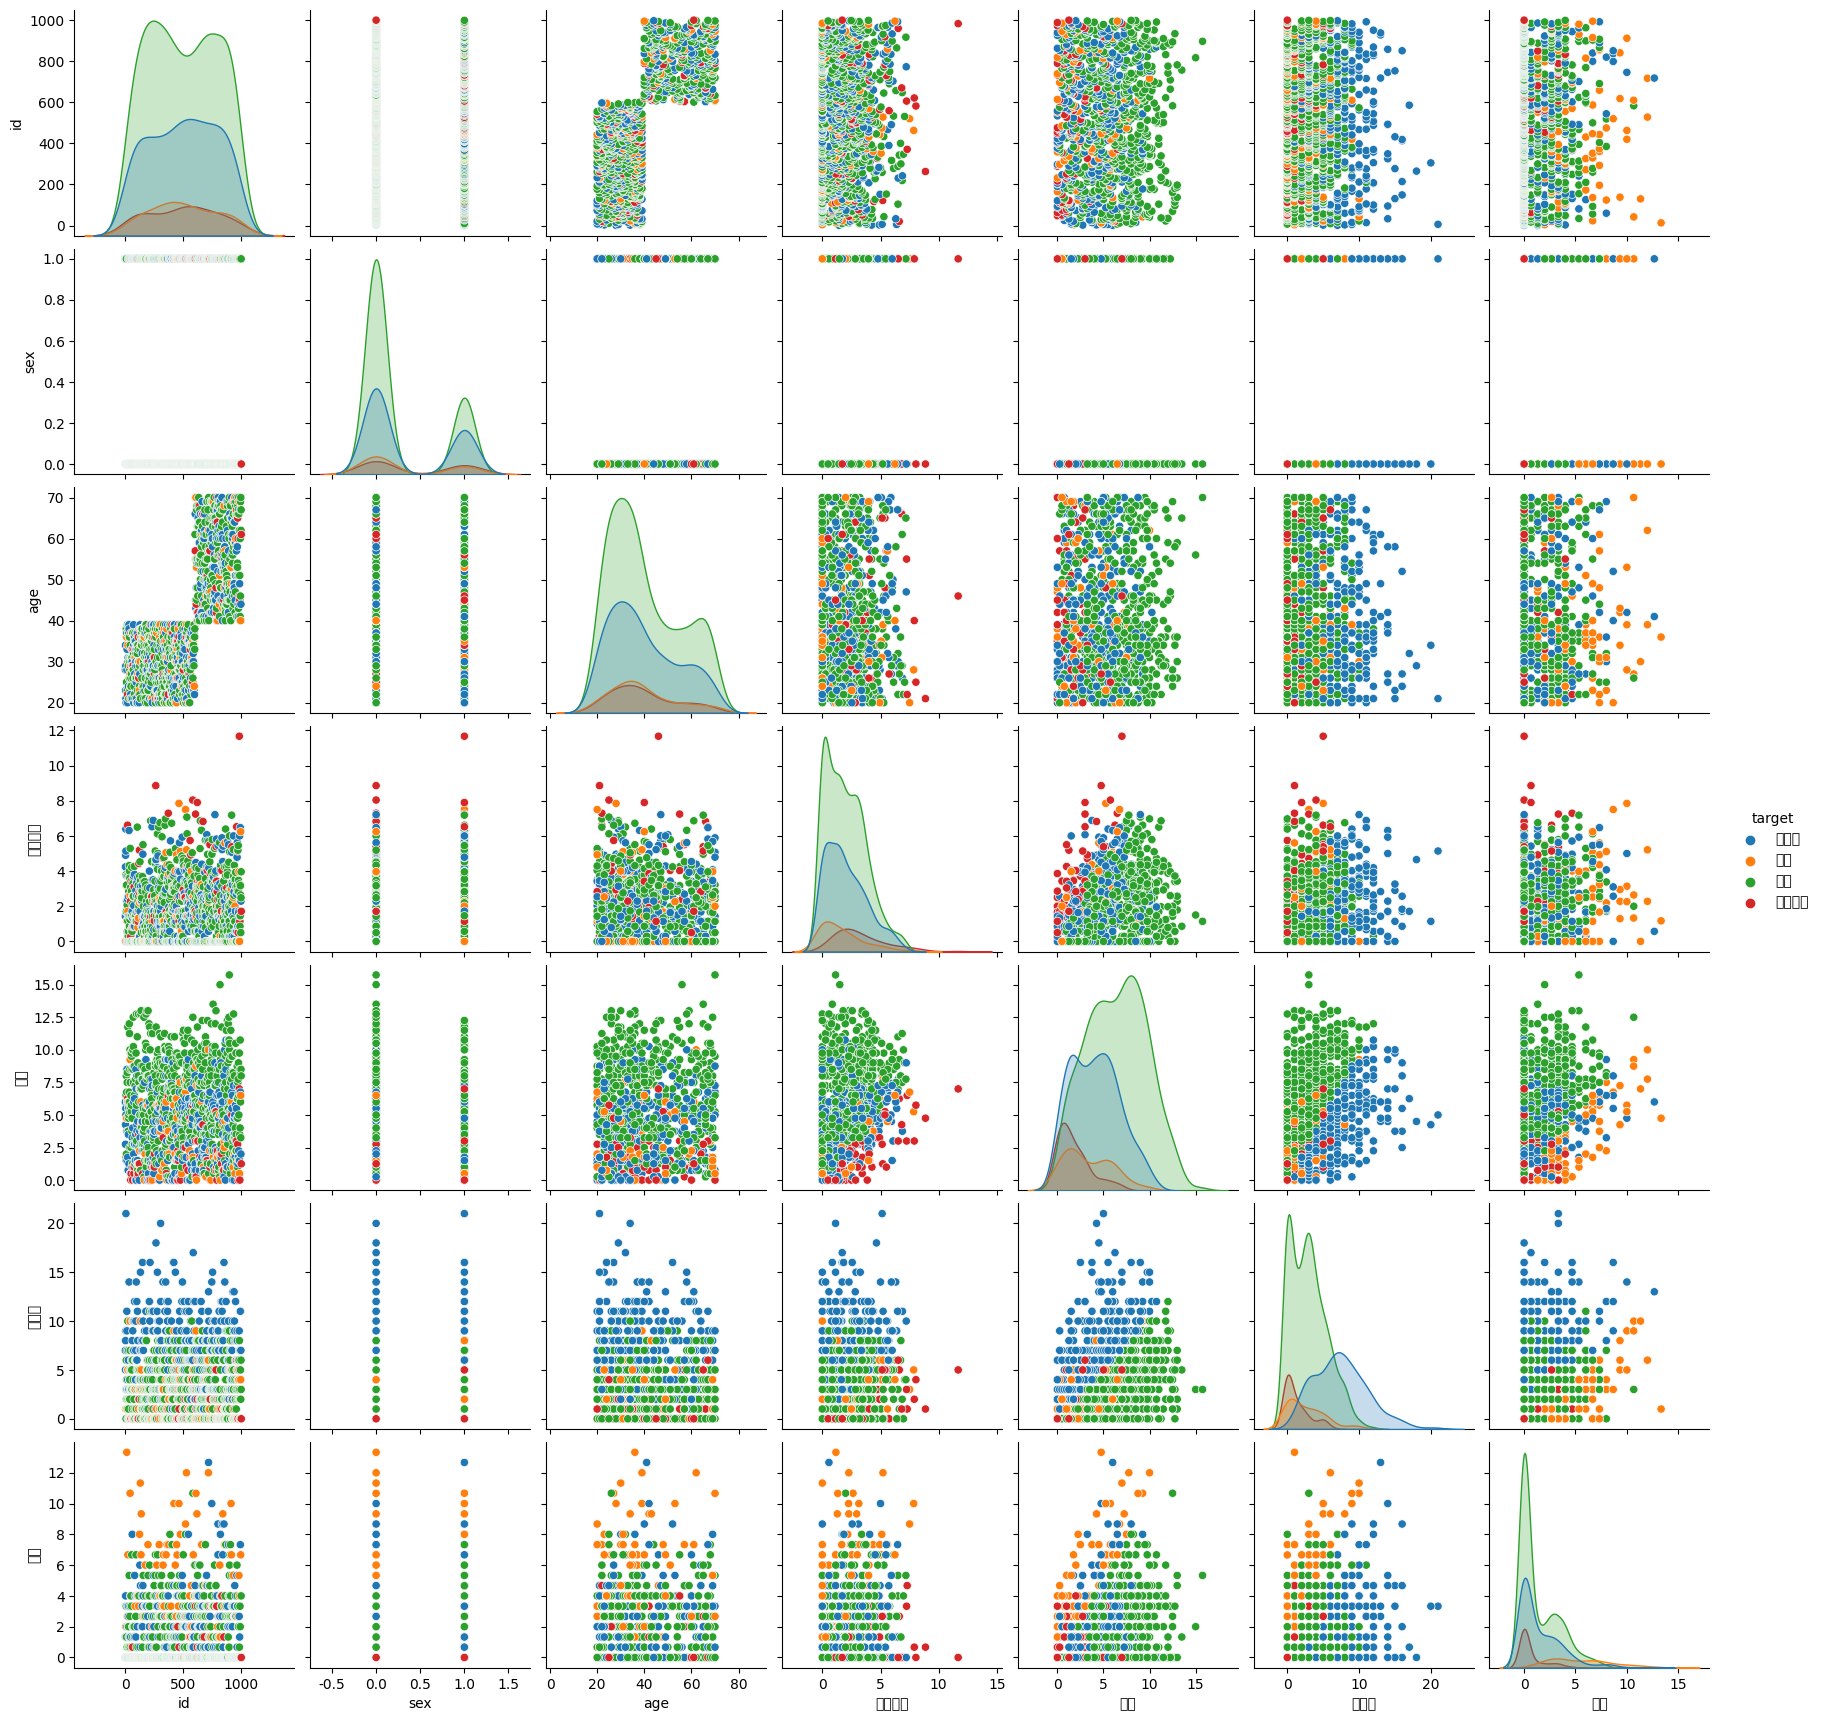

In [70]:
# 데이터의 분포 시각화
sns.pairplot(result5 , hue = 'target')

# 훈련, 테스트 데이터 분리

In [71]:
# address 컬럼 라벨값으로 변경
add = result5.address.unique().tolist()

In [72]:
dic = {}
for i , j in zip(add , np.arange(1,12)):
  dic[i] = j

In [73]:
dic

{'경상도': 1,
 '대전': 2,
 '전라도': 3,
 '광주': 4,
 '강원도': 5,
 '경기도': 6,
 '대구': 7,
 '서울': 8,
 '인천': 9,
 '부산': 10,
 '제주': 11}

In [74]:
result5['address'] = result5['address'].map(dic)

# 모델링

In [75]:
data = result5[['sex','age','address']]
target = result5['target']

In [76]:
train_input , test_input , train_target , test_target = train_test_split(data , target , random_state = 42 , stratify = target)

In [77]:
#KNN(K-nearest neighbor)
knn = KNeighborsClassifier()
knn.fit(train_input, train_target)

## train, test 정확도
print(knn.score(train_input, train_target))
print(knn.score(test_input, test_target))

0.6186666666666667
0.44


In [78]:
#Rogistic Regression
lr = LogisticRegression()
lr.fit(train_input, train_target)

## train, test 정확도
print(lr.score(train_input, train_target))
print(lr.score(test_input, test_target))

0.552
0.552


In [79]:
#Decision Tree
dt = DecisionTreeClassifier()
dt.fit(train_input, train_target)

## train, test 정확도
print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.824
0.372


In [80]:
#Random Forest
rf = RandomForestClassifier()
rf.fit(train_input, train_target)

## train, test 정확도
print(rf.score(train_input, train_target))
print(rf.score(test_input, test_target))

0.824
0.432


## 성능이 가장 좋다고 판단된 LogisticRegression을 활용

In [81]:
#교차 검증
cross = cross_validate(lr , train_input , train_target , cv = 10 , return_train_score = True)

In [82]:
cross

{'fit_time': array([0.03408861, 0.03159308, 0.03013945, 0.03601861, 0.03121614,
        0.02948856, 0.03076887, 0.0296967 , 0.03041601, 0.02942371]),
 'score_time': array([0.00259781, 0.00298452, 0.00245428, 0.00261164, 0.00287914,
        0.002424  , 0.00248265, 0.00247049, 0.0024035 , 0.00244021]),
 'test_score': array([0.54666667, 0.54666667, 0.54666667, 0.56      , 0.56      ,
        0.56      , 0.56      , 0.54666667, 0.54666667, 0.54666667]),
 'train_score': array([0.55259259, 0.55259259, 0.55259259, 0.55111111, 0.55111111,
        0.55111111, 0.55111111, 0.55259259, 0.55259259, 0.55259259])}

In [83]:
print(cross['train_score'].mean(), cross['test_score'].mean())

0.5519999999999999 0.552


In [84]:
#Grid SearchCV
params = {'C' : [0.001,0.01,0.1,1,10],
          'max_iter' : [10,100,1000,10000]}

In [85]:
gs = GridSearchCV(lr , params , cv = 10)

In [86]:
gs.fit(train_input , train_target)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'max_iter': [10, 100, 1000, 10000]})

In [87]:
gs.best_estimator_

LogisticRegression(C=0.001, max_iter=10)

In [88]:
lr_best = LogisticRegression(C = 0.001 , max_iter = 10, random_state = 42)
lr_best.fit(train_input , train_target)

print(lr_best.score(train_input, train_target))
print(lr_best.score(test_input, test_target))

0.552
0.552


# 신규 데이터 예상

In [89]:
def login():
  print('주소 : ' , dic)
  a , b , c = input('인적사항을 입력해주세요 : 1. 나이 , 2. 성별(남/여) , 3. 주소 : ').split(' ')
  if b == '남':
    b = 1
  elif b == '여':
    b = 0


  c = dic[c]

  data = pd.DataFrame(pd.Series({'sex' : b , 'age' : a , 'address' : c})).T
  result = lr_best.predict(data)

  print('고객님에게 추천드리는 상품 카테고리입니다.\n' , result)

In [90]:
login()

주소 :  {'경상도': 1, '대전': 2, '전라도': 3, '광주': 4, '강원도': 5, '경기도': 6, '대구': 7, '서울': 8, '인천': 9, '부산': 10, '제주': 11}
인적사항을 입력해주세요 : 1. 나이 , 2. 성별(남/여) , 3. 주소 : 38 남 대구
고객님에게 추천드리는 상품 카테고리입니다.
 ['이너']
